# Hands-on Activity 6: Building a profile HMM of the HIV pol region

CSC771M 
Members: Bawa, Roxas, Uy

In [26]:
# importing dependencies
import requests
import pandas as pd
import io
import time
from time import sleep
import subprocess
from Bio import AlignIO
from collections import Counter
import matplotlib.pyplot as plt
import re
import seaborn as sns
import numpy as np


## Step 1: Collecting HIV-1 gag-pol Protein Sequences
For the first step, we gathered the necessary input data which were the HIV-1 gag-pol polyprotein sequences. Rather than relying on a single reference genome (such as the previous Hands-On), which may not sufficiently represent the genetic diversity of HIV-1, we aim to build a more comprehensive model using sequences from multiple subtypes. We retrieved 30 reviewed (Swiss-Prot) gag-pol sequences from the UniProtKB database. These sequences will later be aligned and used to train a robust pHMM that can more effectively capture the variability of the pol region across different HIV strains.

In [27]:
# Set up basic parameters
BASE_URL = "https://rest.uniprot.org/uniprotkb/search"
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (compatible; bioinformatics-student/1.0)'
}

In [28]:
# Define query functions
def search_uniprot(query, format_type="fasta", limit=500):
    params = {
        'query': query,
        'format': format_type,
        'size': limit
    }
    
    try:
        response = requests.get(BASE_URL, params=params, headers=HEADERS)
        response.raise_for_status()
        
        if format_type == "fasta":
            return response.text
        elif format_type == "tsv":
            return pd.read_csv(io.StringIO(response.text), sep='\t')
        else:
            return response.json()
            
    except requests.RequestException as e:
        print(f"Error fetching data: {e}")
        return None

def get_fasta(accession):
    url = f"https://rest.uniprot.org/uniprotkb/{accession}.fasta"
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.text
    except requests.RequestException as e:
        print(f"Error fetching FASTA for {accession}: {e}")
        return None

In [29]:
hiv_query = (
    'taxonomy_id:11676 '
    'AND (gag-pol OR "gag pol") '
    'AND reviewed:true '
)

print("Searching UniProt for HIV gag-pol sequences...")
print(f"Query: {hiv_query}")

metadata_query = hiv_query
metadata = search_uniprot(metadata_query, format_type="tsv", limit=100)

if metadata is not None:
    print(f"\nFound {len(metadata)} potential sequences")
    print("\nColumns available:", list(metadata.columns))
    print("\nFirst few entries:")
    display(metadata.head())
else:
    print("No results found with the current query")

Searching UniProt for HIV gag-pol sequences...
Query: taxonomy_id:11676 AND (gag-pol OR "gag pol") AND reviewed:true 

Found 79 potential sequences

Columns available: ['Entry', 'Entry Name', 'Reviewed', 'Protein names', 'Gene Names', 'Organism', 'Length']

First few entries:


,Entry,Entry Name,Reviewed,Protein names,Gene Names,Organism,Length
0,P12498,POL_HV1J3,reviewed,Gag-Pol polyprotein (Pr160Gag-Pol) [Cleaved in...,gag-pol,Human immunodeficiency virus type 1 group M su...,532
1,P05960,POL_HV1C4,reviewed,Gag-Pol polyprotein (Pr160Gag-Pol) [Cleaved in...,gag-pol,Human immunodeficiency virus type 1 group M su...,550
2,P18802,POL_HV1ND,reviewed,Gag-Pol polyprotein (Pr160Gag-Pol) [Cleaved in...,gag-pol,Human immunodeficiency virus type 1 group M su...,1432
3,P03367,POL_HV1BR,reviewed,Gag-Pol polyprotein (Pr160Gag-Pol) [Cleaved in...,gag-pol,Human immunodeficiency virus type 1 group M su...,1447
4,O12158,POL_HV192,reviewed,Gag-Pol polyprotein (Pr160Gag-Pol) [Cleaved in...,gag-pol,Human immunodeficiency virus type 1 group M su...,1431


Here we can see that we found 79 potential sequences from our query search. To build a diverse and representative profile HMM, we want gag-pol sequences from different subtypes of HIV-1. So for this project, we chose Group M, which is the major pandemic group and contains subtypes A–K, to be representative of the different types of HIV-1. After a quick review in UniProtKB, we simply had to change our query with ```taxonomy_id:388795```.

In [30]:
revised_query = (
    'taxonomy_id:388795 '
    'AND (gag-pol OR "gag pol") '
    'AND reviewed:true '
)

print("\nSearching UniProt for HIV-1 gag-pol sequences...")
print(f"Query: {revised_query}")

metadata_revised = search_uniprot(revised_query, format_type="tsv", limit=100)

if metadata_revised is not None:
    pd.set_option('display.max_colwidth', None)
    print(metadata_revised['Organism'].value_counts())
    pd.reset_option('display.max_colwidth')
else:
    print("No results found with the current query")

# Count total number of sequences
total_sequences = len(metadata_revised)
print(f"\nTotal number of sequences found: {total_sequences}")


Searching UniProt for HIV-1 gag-pol sequences...
Query: taxonomy_id:388795 AND (gag-pol OR "gag pol") AND reviewed:true 
Organism
Human immunodeficiency virus type 1 group M subtype C (isolate 92BR025) (HIV-1)        2
Human immunodeficiency virus type 1 group M subtype G (isolate SE6165) (HIV-1)         2
Human immunodeficiency virus type 1 group M subtype B (isolate ARV2/SF2) (HIV-1)       2
Human immunodeficiency virus type 1 group M subtype H (isolate 90CF056) (HIV-1)        2
Human immunodeficiency virus type 1 group M subtype J (isolate SE9280) (HIV-1)         2
Human immunodeficiency virus type 1 group M subtype F1 (isolate VI850) (HIV-1)         2
Human immunodeficiency virus type 1 group M subtype H (isolate VI991) (HIV-1)          2
Human immunodeficiency virus type 1 group M subtype C (isolate ETH2220) (HIV-1)        2
Human immunodeficiency virus type 1 group M subtype G (isolate 92NG083) (HIV-1)        2
Human immunodeficiency virus type 1 group M subtype J (isolate SE917

In [31]:
fasta_sequences = []

for acc in metadata_revised['Entry']:
    fasta = get_fasta(acc)
    if fasta:
        fasta_sequences.append(fasta)
    time.sleep(1)

with open("hiv1_groupM_gagpol.fasta", "w") as f:
    f.write('\n'.join(fasta_sequences))

print(f"Saved {len(fasta_sequences)} sequences to hiv1_groupM_gagpol.fasta")

Saved 36 sequences to hiv1_groupM_gagpol.fasta


## Step 2: Multiple Sequence Alignment of gag-pol Sequences
With our curated dataset of HIV-1 group M gag-pol polyproteins in hand, we now proceed to align the sequences using MAFFT, a widely used tool for multiple sequence alignment (MSA). This step is crucial for identifying conserved and variable regions across the different HIV subtypes. By aligning these sequences, we create a structured representation of homologous positions, which serves as the foundation for building a profile Hidden Markov Model (pHMM). The output of this step is an aligned FASTA file containing all sequences in a consistent frame, ready for conversion into a statistical model using HMMER. For our case, we opted to rely on its ```--auto``` mode which intelligently selects the appropriate algorithm based on the input size and complexity. 

In [32]:

input_fasta = "hiv1_groupM_gagpol.fasta"
output_fasta = "hiv1_groupM_gagpol_aligned.fasta"

command = ["mafft", "--auto", input_fasta]

with open(output_fasta, "w") as out_f:
    subprocess.run(command, stdout=out_f)

print(f"Alignment saved to {output_fasta}")

outputhat23=16
treein = 0
compacttree = 0
stacksize: 8176 kb
rescale = 1
All-to-all alignment.
tbfast-pair (aa) Version 7.526
alg=L, model=BLOSUM62, 2.00, -0.10, +0.10, noshift, amax=0.0
0 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   30 / 36
done.

Progressive alignment ... 
STEP    23 /35 
Reallocating..done. *alloclen = 3885
STEP    35 /35 
done.
tbfast (aa) Version 7.526
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
1 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 0
randomseed = 0
blosum 62 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
rescale = 1

   30 / 36
Segment   1/  1    1-1467
STEP 002-001-1  identical.    identical.   

Alignment saved to hiv1_groupM_gagpol_aligned.fasta


STEP 003-021-1  identical.   
Converged.

done
dvtditr (aa) Version 7.526
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 L-INS-i (Probably most accurate, very slow)
 Iterative refinement method (<16) with LOCAL pairwise alignment information

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.



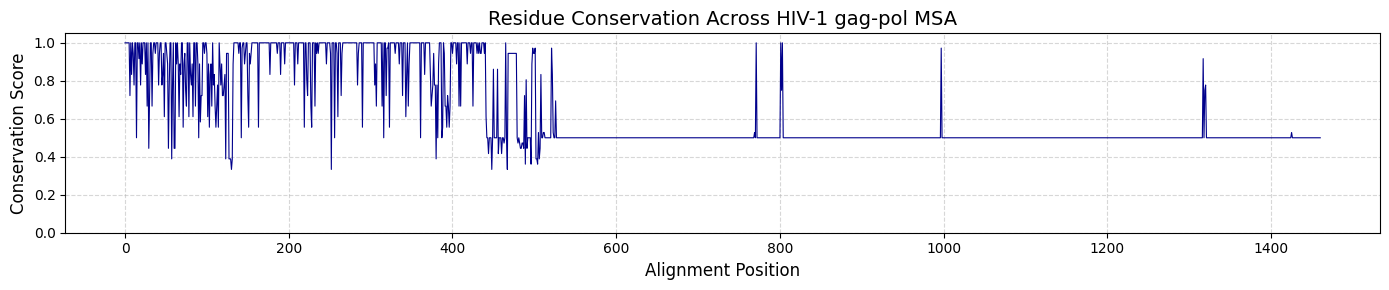

In [33]:
# Load the aligned FASTA file
alignment = AlignIO.read("hiv1_groupM_gagpol_aligned.fasta", "fasta")

# Calculate conservation score at each position
conservation_scores = []

for i in range(alignment.get_alignment_length()):
    column = alignment[:, i]  # Get all residues at position i
    counts = Counter(column)
    most_common_residue, freq = counts.most_common(1)[0]
    conservation_scores.append(freq / len(alignment))  # Normalize by number of sequences

# Plotting
plt.figure(figsize=(14, 3))
plt.plot(conservation_scores, color='darkblue', linewidth=0.8)
plt.title("Residue Conservation Across HIV-1 gag-pol MSA", fontsize=14)
plt.xlabel("Alignment Position", fontsize=12)
plt.ylabel("Conservation Score", fontsize=12)
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

The plot above shows the residue conservation score at each position of the multiple sequence alignment. A residue conservation score measures how similar the amino acids are at each aligned position across all sequences. A score of 1.0 means that every sequence has the same amino acid at that position (fully conserved), while lower scores mean there is more variation among the sequences. In this specific scenario for HIV-1 gag-pol polyprotein, positions with low conservation often show where mutations happen more frequently between different virus strains. It is particularly noticeable that from around position 500 onwards, the conservation score remains fairly consistent at approximately 0.5. These variable regions may be linked to how the virus adapts or becomes resistant to treatment. These conserved patterns will help guide the construction of a reliable profile Hidden Markov Model in the next step.

## Step 3: Building a Profile HMM Using HMMER
With our multiple sequence alignment of HIV-1 gag-pol polyproteins complete, we now proceed to build a profile Hidden Markov Model (pHMM) using the tool HMMER. We use the hmmbuild command from the HMMER suite to generate the pHMM from the aligned FASTA file. The resulting model will serve as a reference for detecting drug resistance mutations by aligning patient-derived sequences to this broader, more representative profile.

In [34]:
# Input and output file paths
aligned_fasta = "hiv1_groupM_gagpol_aligned.fasta"
output_hmm = "hiv1_gagpol.hmm"

# Command to run HMMER's hmmbuild
command = ["hmmbuild", output_hmm, aligned_fasta]

# Run the command and capture output
try:
    result = subprocess.run(command, check=True, capture_output=True, text=True)
    print("HMMER build successful.\n")
    print(result.stdout)  # Show summary output from hmmbuild
except subprocess.CalledProcessError as e:
    print("Error running hmmbuild:")
    print(e.stderr)

HMMER build successful.

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.4 (Aug 2023); http://hmmer.org/
# Copyright (C) 2023 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             hiv1_groupM_gagpol_aligned.fasta
# output HMM file:                  hiv1_gagpol.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     hiv1_groupM_gagpol_aligned    36  1461  1431     0.65  0.589 

# CPU time: 0.19u 0.00s 00:00:00.19 Elapsed: 00:00:00.19

